# Phase 2: Model Selection & Training
**Objective:** Develop a robust classifier to detect fraudulent Nigerian transactions.

In this phase, we move from data engineering to predictive modeling. Because fraud is a "Needle in a Haystack" problem, we will prioritize **Recall** (catching fraud) over **Accuracy**.

### Key Strategies:
1. **Handling Class Imbalance:** Using `class_weight` and Stratified splitting to handle the scarcity of fraud cases.
2. **Algorithm Benchmarking:** Testing Linear (Logistic Regression) vs. Ensemble (XGBoost/LightGBM) models.
3. **Evaluation Metrics:** Focusing on the Confusion Matrix, Precision-Recall curves, and SHAP values.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from src.logger import get_logger

# Configure Logger & Visuals
logger = get_logger("model_training")
plt.style.use('ggplot')
%matplotlib inline

# Load the feature-engineered dataset
try:
    df = pd.read_parquet('../../data/nigerian_fraud_features.parquet')
    logger.info("Successfully loaded engineered features.")
except Exception as e:
    logger.error(f"Error loading parquet file: {e}")

[2025-12-27 11:29:56] INFO [model_training.<module>:18] Successfully loaded engineered features.


## 1. Data Pre-processing
Before feeding data into our models, we must:
* **Encode Categorical Variables:** Convert strings like 'Lagos' or 'USSD' into numerical formats.
* **Stratified Split:** Ensure that the 80/20 split maintains the same percentage of fraud in both sets.

In [3]:
# Categorical columns for encoding
cat_cols = ['sender_bank', 'channel', 'location', 'device_type', 'amount_band']

# Professional Encoding (Label Encoding for tree-based models)
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col].astype(str))

# Feature/Target Separation
X = df.drop(columns=['is_fraud'])
y = df['is_fraud']

# Stratified Split to maintain fraud ratio
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y )

logger.info(f"Splitting complete. Fraud Ratio in Train: {y_train.mean():.4f}")

[2025-12-27 11:29:57] INFO [model_training.<module>:20] Splitting complete. Fraud Ratio in Train: 0.0185


## 2. Baseline Model: Logistic Regression
We start with a linear model to establish a performance floor. We use `class_weight='balanced'` to force the model to penalize the misclassification of fraud more heavily than normal transactions.

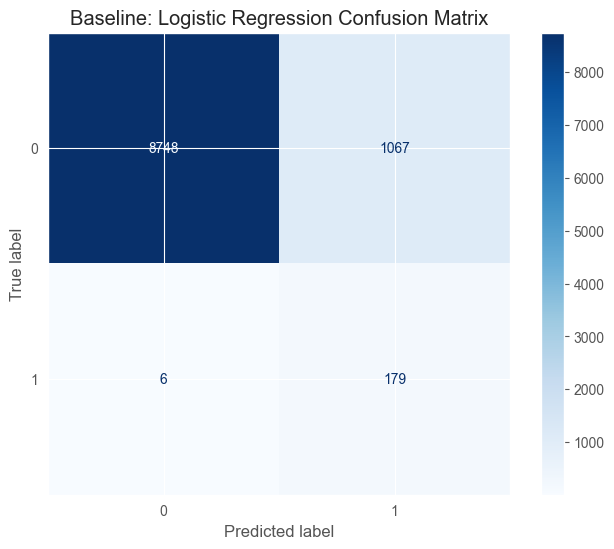

--- Classification Report ---
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      9815
           1       0.14      0.97      0.25       185

    accuracy                           0.89     10000
   macro avg       0.57      0.93      0.60     10000
weighted avg       0.98      0.89      0.93     10000



In [4]:
from sklearn.linear_model import LogisticRegression

# Initialize with balance adjustment
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr_model.fit(X_train, y_train)

# Evaluation
y_pred = lr_model.predict(X_test)

# Plotting Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap='Blues')
plt.title('Baseline: Logistic Regression Confusion Matrix')
plt.show()

print("--- Classification Report ---")
print(classification_report(y_test, y_pred))

## 3. Advanced Model: XGBoost
Logistic Regression is linear, so it struggles to see complex relationships (e.g., "Amount is high AND it's a new device AND it's USSD").

XGBoost uses Gradient Boosting to build "Decision Trees" that can capture these non-linear Nigerian fraud patterns. We will use `scale_pos_weight` to handle the class imbalance.

In [5]:
import xgboost as xgb

# Calculate the scale_pos_weight (ratio of negative to positive classes)
ratio = float(y_train.value_counts()[0] / y_train.value_counts()[1])

# Initialize XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=ratio,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

logger.info(f"Training XGBoost with scale_pos_weight: {ratio:.2f}")
xgb_model.fit(X_train, y_train)

# Predict and Evaluate
y_pred_xgb = xgb_model.predict(X_test)

print("--- XGBoost Classification Report ---")
print(classification_report(y_test, y_pred_xgb))

[2025-12-27 11:30:10] INFO [model_training.<module>:17] Training XGBoost with scale_pos_weight: 53.20


C:\Users\Adminn\TechnoIndustry\FinTech\sentinel-fraud-detection\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [11:30:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- XGBoost Classification Report ---
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      9815
           1       0.26      0.92      0.40       185

    accuracy                           0.95     10000
   macro avg       0.63      0.93      0.69     10000
weighted avg       0.98      0.95      0.96     10000



## 4. Evaluation: Baseline vs. XGBoost
We will now compare the models side-by-side. Our goal is to verify that the ensemble method (XGBoost) provides a better balance between catching fraud and maintaining a good customer experience.

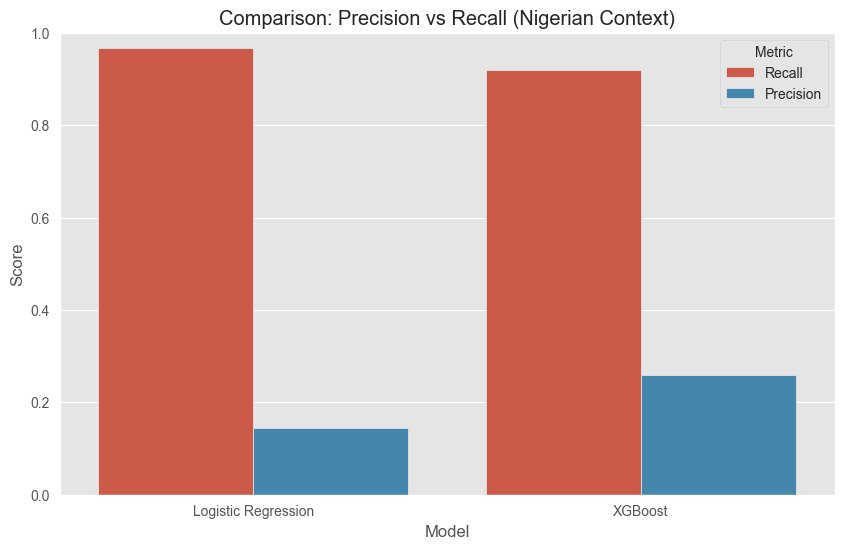

In [6]:
from sklearn.metrics import recall_score, precision_score

models = ['Logistic Regression', 'XGBoost']
recalls = [recall_score(y_test, y_pred), recall_score(y_test, y_pred_xgb)]
precisions = [precision_score(y_test, y_pred), precision_score(y_test, y_pred_xgb)]

df_res = pd.DataFrame({
    'Model': models * 2,
    'Score': recalls + precisions,
    'Metric': ['Recall']*2 + ['Precision']*2
})

plt.figure(figsize=(10, 6))
sns.barplot(data=df_res, x='Model', y='Score', hue='Metric')
plt.title('Comparison: Precision vs Recall (Nigerian Context)')
plt.ylim(0, 1)
plt.show()

## 5. Model Explainability (SHAP)
In a real Nigerian bank, if a transaction is blocked, the support team needs to know *why*.
SHAP (SHapley Additive exPlanations) breaks down exactly which features (Time, Amount, Channel) pushed the model to flag a transaction as fraud.

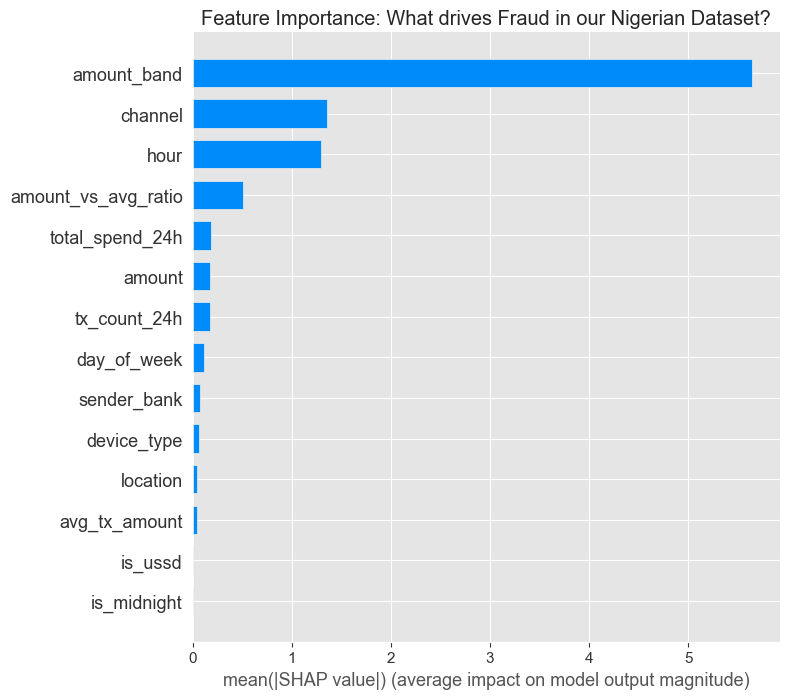

In [7]:
import shap

# Initialize the Explainer
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

# Summary plot: What are the most important features across all transactions?
plt.title("Feature Importance: What drives Fraud in our Nigerian Dataset?")
shap.summary_plot(shap_values, X_test, plot_type="bar")

## 6. Exporting for Production
To use this model in our FastAPI application, we need to save:
1. The trained **XGBoost Model**.
2. The **LabelEncoders** (to transform real-time 'Channel' or 'Location' strings into numbers).

In [8]:
import joblib
import os

# Create models directory if not exists
os.makedirs('../../models', exist_ok=True)

# 1. Save the Model
joblib.dump(xgb_model, '../../models/fraud_model_v1.joblib')

# 2. Save the Encoders (Crucial for the API to work!)
encoders = {col: le for col, le in zip(cat_cols, [le]*len(cat_cols))}
joblib.dump(le, '../../models/label_encoder.joblib')

logger.info("Model and Encoders saved successfully to /models folder.")

[2025-12-27 11:39:32] INFO [model_training.<module>:14] Model and Encoders saved successfully to /models folder.
